In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
"""
LIGAS DISPONIBLES

LaLiga (ESP)
PremierLeague (ING)
SerieA  (ITA)
Bundesliga  (ALE)
Ligue1  (FRA)
"""
dicc_ligas = {'ESP': 'La_liga',
              'ING': 'EPL',
              'ITA': 'Serie_A',
              'ALE': 'Bundesliga',
              'FRA': 'Ligue_1'}

In [3]:
# Para descargar un partido de La Liga 
while True:
    liga = str(input('¿Qué Liga es?: ')).upper()    #ESP
    if liga in dicc_ligas:
        break
    else:
        print('Introduce una liga disponible')
temporada = str(input('¿Qué temporada es?: '))  #23-24
jornada = str(input('¿Qué jornada es?: '))  #33

In [4]:
# ID Almería - Getafe de la jornada 33 -> 23005

# Descarga de datos para el partido al que corresponde el ID
partido = str(input('¿Cuál es el ID del partido que quieres descargar: '))
enlace = 'https://understat.com/match/' + partido

In [5]:
respuesta = requests.get(enlace)    # Petición realizada a la web
sopa = BeautifulSoup(respuesta.text, 'lxml')    # Contenido de la página
scripts = sopa.find_all('script') 
cadena = scripts[1].string # En el segundo script es donde se encuentran los datos que nos interesan
codificar = cadena.encode('utf8').decode('unicode_escape') # Para ver como se disponen los datos del texto con claridad
#codificar
inicio = codificar.index("('") + 2 
final = codificar.index("')") 
datos = codificar[inicio:final]    # Eliminar los caracteres anteriores y posteriores a los datos
datos = json.loads(datos)   # Convertir a json para realizar la extracción de los datos
datos

{'h': [{'id': '576856',
   'minute': '28',
   'result': 'SavedShot',
   'X': '0.7719999694824219',
   'Y': '0.575',
   'xG': '0.028289709240198135',
   'player': 'Dion Lopy',
   'h_a': 'h',
   'player_id': '9450',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '23005',
   'h_team': 'Almeria',
   'a_team': 'Getafe',
   'h_goals': '1',
   'a_goals': '3',
   'date': '2024-04-27 14:15:00',
   'player_assisted': 'Anthony Lozano',
   'lastAction': 'Pass'},
  {'id': '576857',
   'minute': '30',
   'result': 'MissedShots',
   'X': '0.965',
   'Y': '0.3139999961853027',
   'xG': '0.01620151661336422',
   'player': 'César Montes',
   'h_a': 'h',
   'player_id': '11288',
   'situation': 'SetPiece',
   'season': '2023',
   'shotType': 'Head',
   'match_id': '23005',
   'h_team': 'Almeria',
   'a_team': 'Getafe',
   'h_goals': '1',
   'a_goals': '3',
   'date': '2024-04-27 14:15:00',
   'player_assisted': 'Adrián Embarba',
   'lastAction': 'Cross'},
  {'i

In [52]:
# TRATAMIENTO DE LOS DATOS
def datos_equipo(localia):  # Función para obtener los datos de un equipo
    # Para crear un ID del partido
    equipo_local = datos['h'][0]['h_team']  
    equipo_visitante = datos['a'][0]['a_team']  
    # Listas para almacenar los datos correspondientes
    minuto = []
    equipo = []
    xg = []
    jugador = []
    zona_contacto = []
    resultado = []
    x = []
    y = []
    situacion = []
    asistente = []
    accion_anterior = []
    for indice in range(len(localia)):
        for clave in localia[indice]:
            if clave == 'h_a': 
                if localia[indice][clave] == 'h':
                    equipo.append(localia[indice]['h_team'])
                else:
                    equipo.append(localia[indice]['a_team'])
            if clave == 'minute':
                minuto.append(int(localia[indice][clave]))
            if clave == 'xG':
                xg.append(float(localia[indice][clave]))
            if clave == 'player':
                jugador.append(localia[indice][clave])
            if clave == 'shotType':
                zona_contacto.append(localia[indice][clave])
            if clave == 'result':
                resultado.append(localia[indice][clave])
            if clave == 'X':
                x.append(localia[indice][clave])
            if clave == 'Y':
                y.append(localia[indice][clave])
            if clave == 'situation':
                situacion.append(localia[indice][clave])
            if clave == 'player_assisted':
                asistente.append(localia[indice][clave])
            if clave == 'lastAction':
                accion_anterior.append(localia[indice][clave]) # Fin del bucle FOR
    columnas = ['jugador', 'equipo', 'minuto', 'xg', 'zona_contacto', 'resultado', 'x', 'y', 'situacion', 'asistente', 'accion_anterior']
    df = pd.DataFrame([jugador, equipo, minuto, xg, zona_contacto, resultado, x, y, situacion, asistente, accion_anterior],index=columnas)
    df = df.T
    id = dicc_ligas[liga] + '_' + jornada + '_' + temporada + '_' + equipo_local + '-' + equipo_visitante
    df['id'] = id
    df['partido'] = equipo_local + '-' + equipo_visitante
    return df

In [60]:
# Se llama a la función para que nos de los dataframes de los dos equipos
datos_local = datos['h']    
datos_visitante = datos['a']
df_local = datos_equipo(datos_local)
df_visitante = datos_equipo(datos_visitante)
# Más tratamiento de datos
df_equipos = pd.concat([df_local, df_visitante]).reset_index(drop=True)
# Se podrían traducir los datos al español
df_equipos.loc[df_equipos.zona_contacto == 'RightFoot', 'zona_contacto'] = 'Pierna derecha' 
df_equipos.loc[df_equipos.zona_contacto == 'LeftFoot', 'zona_contacto'] = 'Pierna izquierda'
df_equipos.loc[df_equipos.zona_contacto == 'Head', 'zona_contacto'] = 'Cabeza'
df_equipos.loc[df_equipos.zona_contacto == 'OtherBodyPart', 'zona_contacto'] = 'Otra parte del cuerpo'
# Resultado del tiro
df_equipos.loc[df_equipos.resultado == 'MissedShots', 'resultado'] = 'Tiro fuera' 
df_equipos.loc[df_equipos.resultado == 'SavedShot', 'resultado'] = 'Tiro a porteria'
df_equipos.loc[df_equipos.resultado == 'BlockedShot', 'resultado'] = 'Tiro bloqueado'
df_equipos.loc[df_equipos.resultado == 'ShotOnPost', 'resultado'] = 'Tiro al palo'
df_equipos.loc[df_equipos.resultado == 'Goal', 'resultado'] = 'Gol' 
df_equipos.loc[df_equipos.resultado == 'OwnGoal', 'resultado'] = 'Gol en propia'
# Tipo de jugada
df_equipos.loc[df_equipos.situacion == 'OpenPlay', 'situacion'] = 'Juego abierto'
df_equipos.loc[df_equipos.situacion == 'FromCorner', 'situacion'] = 'Remate de corner'
df_equipos.loc[df_equipos.situacion == 'DirectFreekick', 'situacion'] = 'Falta directa'
df_equipos.loc[df_equipos.situacion == 'SetPiece', 'situacion'] = 'Balon parado' 
df_equipos.loc[df_equipos.situacion == 'Penalty', 'situacion'] = 'Penalti'
df_equipos.loc[df_equipos.situacion == 'CounterAttack', 'situacion'] = 'Contraataque'

In [61]:
df_equipos

,jugador,equipo,minuto,xg,zona_contacto,resultado,x,y,situacion,asistente,accion_anterior,id,partido
0,Dion Lopy,Almeria,28,0.02829,LeftFoot,SavedShot,0.7719999694824219,0.575,OpenPlay,Anthony Lozano,Pass,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
1,César Montes,Almeria,30,0.016202,Head,MissedShots,0.965,0.3139999961853027,SetPiece,Adrián Embarba,Cross,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
2,Adrián Embarba,Almeria,31,0.427875,RightFoot,SavedShot,0.8809999847412109,0.5879999923706055,OpenPlay,Jonathan Viera,Pass,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
3,Adrián Embarba,Almeria,40,0.029892,RightFoot,SavedShot,0.9009999847412109,0.3129999923706055,SetPiece,Jonathan Viera,Pass,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
4,Anthony Lozano,Almeria,40,0.566422,RightFoot,Goal,0.955,0.42900001525878906,SetPiece,None,Rebound,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
5,Adrián Embarba,Almeria,42,0.057893,RightFoot,SavedShot,0.8980000305175782,0.674000015258789,OpenPlay,None,None,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
6,Lucas Robertone,Almeria,45,0.048902,LeftFoot,MissedShots,0.9219999694824219,0.669000015258789,FromCorner,Bruno Langa,Pass,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
7,Leo Baptistao,Almeria,47,0.03341,Head,SavedShot,0.905,0.56,SetPiece,Adrián Embarba,Aerial,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
8,Chumi,Almeria,48,0.612066,RightFoot,BlockedShot,0.965,0.46900001525878904,SetPiece,None,None,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe
9,Adrián Embarba,Almeria,53,0.020131,RightFoot,SavedShot,0.8019999694824219,0.755,OpenPlay,Bruno Langa,Pass,La_liga_33_23-24_Almeria-Getafe,Almeria-Getafe


In [2]:
df_tiros = pd.read_excel("ESP_33_23-24_Almeria-Getafe_tiros.xlsx")

In [3]:
def lista_acumulados(lista):   # Función que devuelve una lista con la suma de los valores acumulados de la lista recibida
    return [sum(lista[: i + 1]) for i in range(len(lista))]

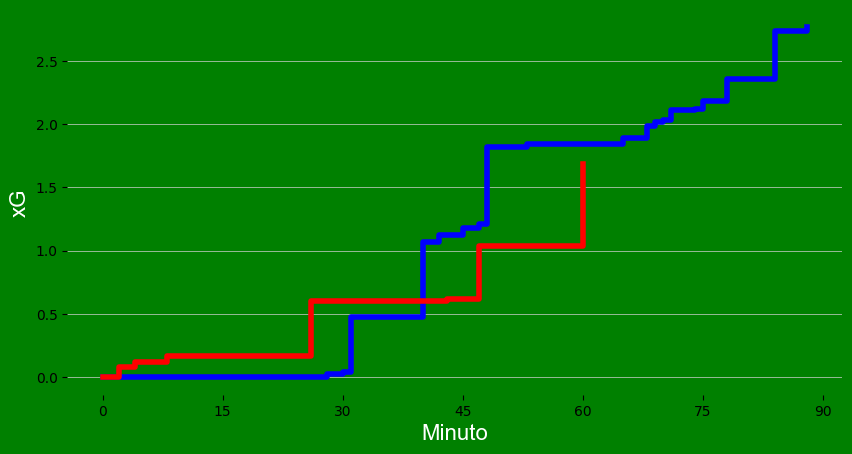

In [14]:
# Visualización de la evolución de xG en el partido
# Listas para los valores que se quieren representar en el gráfico
xg_local = [0]
xg_visitante= [0]
minuto_local = [0]
minuto_vistante = [0]
equipo_local = df_tiros['equipo'].iloc[0]   # Obtener el nombre del equipo local y del visitante
equipo_visitante = df_tiros['equipo'].iloc[-1]
for i in range(len(df_tiros.index)):    # Añadir los valores del dataframe a las listas correspondientes
    if df_tiros['equipo'][i] == equipo_local:
        xg_local.append(df_tiros['xg'][i])
        minuto_local.append(df_tiros['minuto'][i])
    else:
        xg_visitante.append(df_tiros['xg'][i])
        minuto_vistante.append(df_tiros['minuto'][i])
xg_local_total = lista_acumulados(xg_local) # Llamada a la función que calcula la lista acumulada
xg_visitante_total = lista_acumulados(xg_visitante)
max_xg_local = round(xg_local_total[-1], 2) # Redondear a dos decimales el valor máximo de xG
max_xg_visitante = round(xg_visitante_total[-1], 2)
# Comienzo del diseño del gráfico
fig, ax = plt.subplots(figsize = (10, 5))    # Determinar el tamaño y el color del gráfico
fig.set_facecolor('green')
ax.patch.set_facecolor('green')
ax.grid(lw=.5, color='lightgrey', axis='y', zorder=1)   # Añadir una grilla en el eje y
#ax.grid(lw=.5, color='lightgrey', axis='x', zorder=1)
limites = ['right', 'bottom', 'left', 'top']
for i in limites:
    if i in limites:
        ax.spines[i].set_visible(False)    # Desactivar los límites del gráfico
plt.xticks([0, 15, 30, 45, 60, 75, 90]) # Determinar el intervalo del eje x 
# Dar un nombre a los ejes
plt.xlabel('Minuto', fontname='Arial', color='white', fontsize=16)
plt.ylabel('xG', fontname='Arial', color='white', fontsize=16)  
# Añadir las líneas de la evolución de xG de cada equipo
ax.step(x=minuto_local, y=xg_local_total, color='blue', label=equipo_local, linewidth=4, where='post') 
ax.step(x=minuto_vistante, y=xg_visitante_total, color='red', label=equipo_visitante, linewidth=4, where='post')